# Wavefront propagation simulation tutorial - Case 3

L.Samoylova <liubov.samoylova@xfel.eu>, A.Buzmakov <buzmakov@gmail.com>

Tutorial course on Wavefront Propagation Simulations, 28/11/2013, European XFEL, Hamburg.

Wave optics software is based on SRW core library <https://github.com/ochubar/SRW>, available through WPG interactive framework <https://github.com/samoylv/WPG>

## Propagation Gaussian through HOM and KB optics: extended analysis

### Import modules

In [1]:
%matplotlib inline

In [2]:
#Importing necessary modules:

import os
import sys
sys.path.insert(0,os.path.join('..','..'))

import time
import copy
import numpy as np
import pylab as plt


#import SRW core functions
from wpg.srwlib import srwl,SRWLOptD,SRWLOptA,SRWLOptC,SRWLOptT,SRWLOptL,SRWLOptMirEl

#import SRW helpers functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

#import some helpers functions
from wpg.useful_code.wfrutils import calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh, plot_1d, plot_2d
from wpg.useful_code.wfrutils import  propagate_wavefront
#Import base wavefront class
from wpg import Wavefront

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy

from wpg import Beamline
from wpg.optical_elements import Empty, Use_PP

plt.ion()

### Define auxiliary functions

In [3]:
def calculate_source_fwhm(ekev, theta_fwhm):
    """
    Calculate source size from photon energy and FWHM angular divergence
    
    :param evev: Energy in keV
    :param theta_fwhm: theta_fwhm [units?] 
    """
    wl = 12.39e-10/ekev
    k = 2 * np.sqrt(2*np.log(2))
    theta_sigma = theta_fwhm /k
    sigma0 = wl /(2*np.pi*theta_sigma)
    return sigma0*k

def calculate_theta_fwhm_cdr(ekev,qnC):
    """
    Calculate angular divergence using formula from XFEL CDR2011
    
    :param ekev: Energy in keV
    :param qnC: e-bunch charge, [nC]
    :return: theta_fwhm [units?]
    """
    theta_fwhm = (17.2 - 6.4 * np.sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

def defineOPD(opTrErMirr, mdatafile, ncol, delim, Orient, theta, scale):
    """
    Define optical path difference (OPD) from mirror profile, i.e. ill the struct opTrErMirr
    
    :params mdatafile: an ascii file with mirror profile data
    :params ncol: number of columns in the file
    :params delim: delimiter between numbers in an row, can be space (' '), tab '\t', etc
    :params orient: mirror orientation, 'x' (horizontal) or 'y' (vertical)
    :params theta: incidence angle
    :params scale: scaling factor for the mirror profile    
    """
    heightProfData = np.loadtxt(mdatafile).T
    AuxTransmAddSurfHeightProfileScaled(opTrErMirr, heightProfData, Orient, theta, scale)
    plt.figure()
    plot_1d(heightProfData,'profile from ' + mdatafile,'x (m)', 'h (m)')


### Defining initial wavefront and writing electric field data to h5-file

*****defining initial wavefront and writing electric field data to h5-file...
waist_fwhm [um], theta_fwhms [urad]: 28.3217691481 3.86399794107
save hdf5: g5_0kev.h5


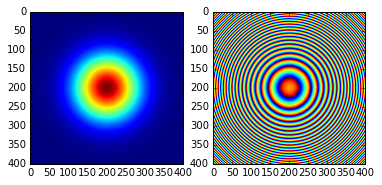

FWHMx [mm]: 0.943784566665
FWHMy [mm]: 0.943784566665
Coordinates of center, [mm]: 0.0035480622807 0.0035480622807
stepX, stepY [um]: 7.096124561394084 7.096124561394084 

R-space
FWHMx [mm], theta_fwhm [urad]: 0.943784566665 3.82874063556


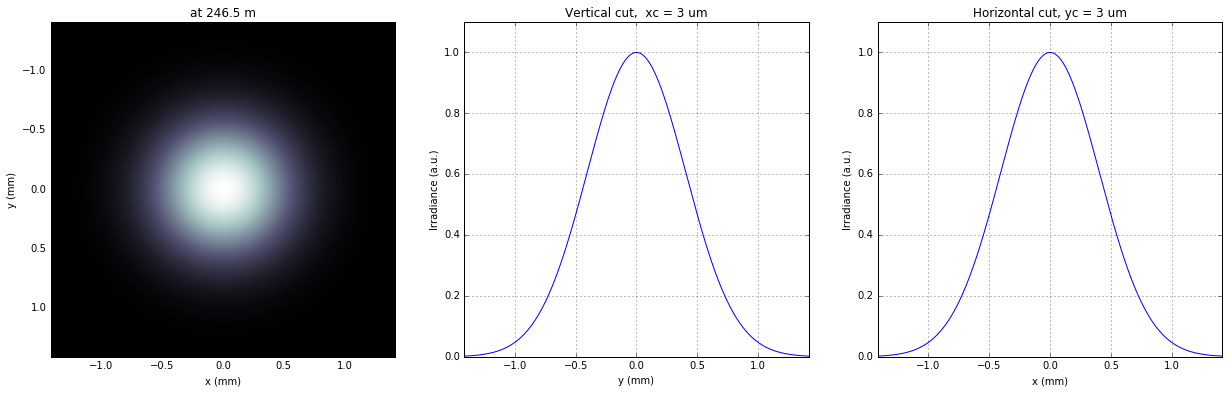

In [4]:
# #**********************Input Wavefront Structure and Parameters
print('*****defining initial wavefront and writing electric field data to h5-file...')
strInputDataFolder = 'data_common'  # input data sub-folder name
strOutputDataFolder = 'Tutorial_case_3'  # output data sub-folder name

#init Gauusian beam parameters
d2m1_sase1 = 246.5
d2m1_sase2 = 290.0
d2m1_sase3 = 281.0

d2hkb_sase1 = 929.6       # distance to nmKB's HFM
dHKB_foc_sase1 = 3.0      # nominal focal length for HFM KB
dVKB_foc_sase1 = 1.9      # nominal focal length for VFM KB
d2hkb_sase3 = 442.3
dHKB_foc_sase3 = 2.715    # nominal focal length for HFM KB
dVKB_foc_sase3 = 1.715    # nominal focal length for VFM KB


qnC = 0.1                    # e-bunch charge, [nC]
ekev_sase3 = 0.8
thetaOM_sase3 = 9.e-3
thetaKB_sase3 = 9.e-3
ekev_sase1 = 5.0
thetaOM_sase1 = 3.5e-3       # 
thetaKB_sase1 = 3.5e-3

ekev = ekev_sase1
thetaOM = thetaOM_sase1
d2m1 = d2m1_sase1
d2hkb = d2hkb_sase1
thetaKB = thetaKB_sase1
dhkb_foc = dHKB_foc_sase1     # nominal focal length for HFM KB
dvkb_foc = dVKB_foc_sase1      # nominal focal length for VFM KB
dhkb_vkb = dhkb_foc - dvkb_foc          # distance between centers of HFM and VFM

z1 = d2m1
theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
k = 2*np.sqrt(2*np.log(2))
sigX = 12.4e-10*k/(ekev*4*np.pi*theta_fwhm) 
print('waist_fwhm [um], theta_fwhms [urad]:', sigX*k*1e6, theta_fwhm*1e6)
#define limits
range_xy = theta_fwhm/k*z1*7. # sigma*7 beam size
npoints=400

#define unique filename for storing results
ip = np.floor(ekev)
frac = np.floor((ekev - ip)*1e3)
fname0 = 'g' + str(int(ip))+'_'+str(int(frac))+'kev'
print('save hdf5: '+fname0+'.h5')
ifname = os.path.join(strOutputDataFolder,fname0+'.h5')

#tiltX = theta_rms
#build SRW gauusian wavefront
wfr0=build_gauss_wavefront_xy(nx=npoints, ny=npoints, ekev=ekev,
                              xMin=-range_xy/2, xMax=range_xy/2,
                              yMin=-range_xy/2, yMax=range_xy/2,
                              sigX=sigX, sigY=sigX, d2waist=z1,
                              xoff=0, yoff=0, tiltX=0, tiltY=0)    

#init WPG Wavefront helper class
mwf = Wavefront(wfr0)

#store wavefront to HDF5 file 
mwf.store_hdf5(ifname)

#draw wavefront with common functions
plt.subplot(1,2,1)
plt.imshow(mwf.get_intensity(slice_number=0))
plt.subplot(1,2,2)
plt.imshow(mwf.get_phase(slice_number=0,polarization='horizontal'))
plt.show()

#draw wavefront with cuts
plot_wfront(mwf, title_fig='at '+str(z1)+' m',
            isHlog=False, isVlog=False,
            i_x_min=1e-5, i_y_min=1e-5, orient='x', onePlot=True)

plt.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
fwhm_x = calculate_fwhm_x(mwf)
print('FWHMx [mm], theta_fwhm [urad]:',fwhm_x*1e3,fwhm_x/z1*1e6)

### Defining optical beamline(s) 

*****Defining optical beamline(s) ...
*****HOM1 data for BL1 beamline 


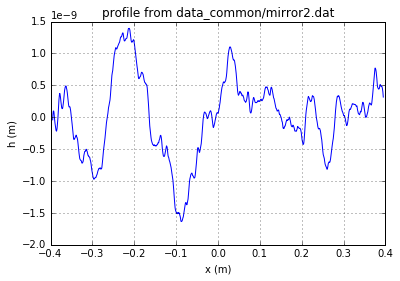

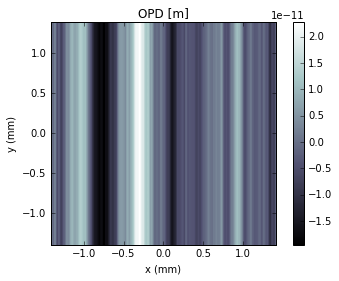

In [6]:
print('*****Defining optical beamline(s) ...')

z2 = d2hkb - d2m1

DriftM1_KB = SRWLOptD(z2) #Drift from first offset mirror (M1) to exp hall
horApM1 = 0.8*thetaOM
opApM1 = SRWLOptA('r', 'a', horApM1, range_xy)  # clear aperture of the Offset Mirror(s)
horApKB = 0.8 * thetaKB # Aperture of the KB system, CA 0.8 m
opApKB = SRWLOptA('r', 'a', horApKB, horApKB)  # clear aperture of the Offset Mirror(s)

#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#                 [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11] 
ppM1 =            [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppTrErM1 =        [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftM1_KB =    [ 0,  0, 1.0,  1,  0, 2.4, 1.8, 2.4, 1.8,  0,  0,   0]
ppApKB =          [ 0,  0, 1.0,  0,  0, 0.6, 8.0, 0.6, 4.0,  0,  0,   0]
ppHKB =           [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppTrErHKB =       [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDrift_HKB_foc = [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDrift_KB =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppVKB =           [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppTrErVKB =       [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDrift_foc =     [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
#ppFin  =          [ 0,  0, 1.0,  0,  0, 0.05,5.0, 0.05,5.0,  0,  0,   0]
ppFin =           [ 0,  0, 1.0,  0,  1, .01, 20.0, .01, 20.0,  0,  0,   0]

optBL0 = SRWLOptC([opApM1,  DriftM1_KB], 
                    [ppM1,ppDriftM1_KB]) 

scale = 2     #5 mirror profile scaling factor 
print('*****HOM1 data for BL1 beamline ')
opTrErM1 = SRWLOptT(1500, 100, horApM1, range_xy)
#defineOPD(opTrErM1, os.path.join(strInputDataFolder,'mirror1.dat'), 2, '\t', 'x',  thetaOM, scale)
defineOPD(opTrErM1, os.path.join(strInputDataFolder,'mirror2.dat'), 2, ' ', 'x',  thetaOM, scale)
opdTmp=np.array(opTrErM1.arTr)[1::2].reshape(opTrErM1.mesh.ny,opTrErM1.mesh.nx)
plt.figure()
plot_2d(opdTmp, opTrErM1.mesh.xStart*1e3,opTrErM1.mesh.xFin*1e3,opTrErM1.mesh.yStart*1e3,opTrErM1.mesh.yFin*1e3,
        'OPD [m]', 'x (mm)', 'y (mm)')  

optBL1 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB], 
                    [ppM1,ppTrErM1,ppDriftM1_KB]) 

dhkb_vkb = dhkb_foc - dvkb_foc          # distance between centers of HFM and VFM
d2vkb = d2hkb +  dhkb_vkb
vkbfoc =  1. /(1./dvkb_foc + 1. / d2vkb) # for thin lens approx
hkbfoc =  1. /(1./dhkb_foc + 1. / d2hkb) # for thin lens approx 

z3 = dhkb_vkb
z4 = vkbfoc #distance to focal plane

#HKB = SRWLOptMirEl(_p=d2hkb, _q=dhkb_foc, _ang_graz=thetaKB, _r_sag=1.e+40, _size_tang=0.85, _nvx=cos(thetaKB), _nvy=0, _nvz=-sin(thetaKB), _tvx=-sin(thetaKB), _tvy=0, _x=0, _y=0, _treat_in_out=1) #HKB Ellipsoidal Mirror
#VKB = SRWLOptMirEl(_p=d2vkb, _q=dvkb_foc, _ang_graz=thetaKB, _r_sag=1.e+40, _size_tang=0.85, _nvx=0, _nvy=cos(thetaKB), _nvz=-sin(thetaKB), _tvx=0, _tvy=-sin(thetaKB), _x=0, _y=0, _treat_in_out=1) #VKB Ellipsoidal Mirror
HKB = SRWLOptL(hkbfoc) #HKB as Thin Lens
VKB = SRWLOptL(1e23,vkbfoc) #VKB as Thin Lens
Drift_KB  = SRWLOptD(z3)
Drift_foc = SRWLOptD(z4)
optBL2 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB,opApKB, HKB,   Drift_KB,  VKB,  Drift_foc], 
                    [ppM1,ppTrErM1,ppDriftM1_KB,ppApKB,ppHKB,ppDrift_KB,ppVKB,ppDrift_foc,ppFin]) 


### Propagating through BL0 beamline. Ideal mirror: HOM as an aperture

In [7]:
print('*****Ideal mirror: HOM as an aperture')
bPlotted = False
isHlog = False
isVlog = False
bSaved = True
optBL = optBL0
strBL = 'bl0'
pos_title = 'at exp hall wall'
print('*****setting-up optical elements, beamline:', strBL)
bl = Beamline(optBL)
print(bl)

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'.h5')
    print('save hdf5:', out_file_name)
else:
    out_file_name = None
    
startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min')

*****Ideal mirror: HOM as an aperture
*****setting-up optical elements, beamline: bl0
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0028000000000000004
	Dy = 0.0028313537
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.8, 2.4, 1.8, 0, 0, 0]
	L = 683.1
	treat = 0
	

save hdf5: Tutorial_case_3/g5_0kev_bl0.h5
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0028000000000000004
	Dy = 0.0028313537
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.8, 2.4, 1.8, 0, 0, 0]
	L = 683.1
	treat = 0
	

*****reading wavefront from h5 file...
nx   400  range_x [-1.4e-03, 1.4e-03]
ny   400  range_y [-1.4e-03, 1.4e-03]
*****propagating wavefront (with resizing)...
propagation lasted: 0.0 min


*****Ideal mirror: HOM as an aperture
FWHMx [mm]: 3.58585062243
FWHMy [mm]: 3.55209077523
Coordinates of center, [mm]: -0.0489384079984 0.0134209978913
stepX, stepY [um]: 8.897892363337482 8.94733192752122 

R-space
FWHMx [mm], theta_fwhm [urad]: 3.58585062243 3.85741245958
FWHMy [mm], theta_fwhm [urad]: 3.55209077523 3.8210959286


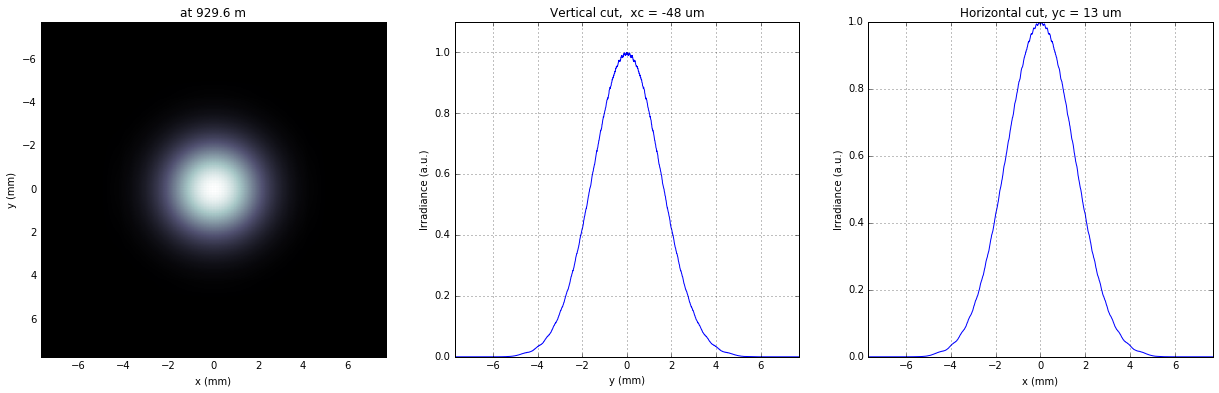

In [8]:
print('*****Ideal mirror: HOM as an aperture')
plot_wfront(mwf, 'at '+str(z1+z2)+' m',False, False, 1e-5,1e-5,'x', True)
#plt.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
plt.axis('tight')    
print('FWHMx [mm], theta_fwhm [urad]:',calculate_fwhm_x(mwf)*1e3,calculate_fwhm_x(mwf)/(z1+z2)*1e6)
print('FWHMy [mm], theta_fwhm [urad]:',calculate_fwhm_y(mwf)*1e3,calculate_fwhm_y(mwf)/(z1+z2)*1e6)

### Propagating through BL1 beamline. Imperfect mirror, at KB aperture

In [11]:
print('*****Imperfect HOM mirror, at KB aperture')
bPlotted = False
isHlog = True
isVlog = False
bSaved = False
optBL = optBL1
strBL = 'bl1'
pos_title = 'at exp hall wall'
print('*****setting-up optical elements, beamline:', strBL)
bl = Beamline(optBL)
print(bl)

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'.h5')
    print('save hdf5:', out_file_name)
else:
    out_file_name = None
    
startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min')

*****Imperfect HOM mirror, at KB aperture
*****setting-up optical elements, beamline: bl1
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0028000000000000004
	Dy = 0.0028313537
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 300000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1500
		ny = 100
		xFin = 0.0014000000000000002
		xStart = -0.0014000000000000002
		yFin = 0.00141567685
		yStart = -0.00141567685
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.8, 2.4, 1.8, 0, 0, 0]
	L = 683.1
	treat = 0
	

Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0028000000000000004
	

*****Imperfect HOM mirror, at KB aperture
FWHMx [mm]: 2.89758221191
FWHMy [mm]: 3.55209077523
Coordinates of center, [mm]: -0.968117421268 0.0134209978913
stepX, stepY [um]: 13.540103793954389 8.94733192752122 

R-space
FWHMx [mm], theta_fwhm [urad]: 2.89758221191 3.11702045171
FWHMy [mm], theta_fwhm [urad]: 3.55209077523 3.8210959286


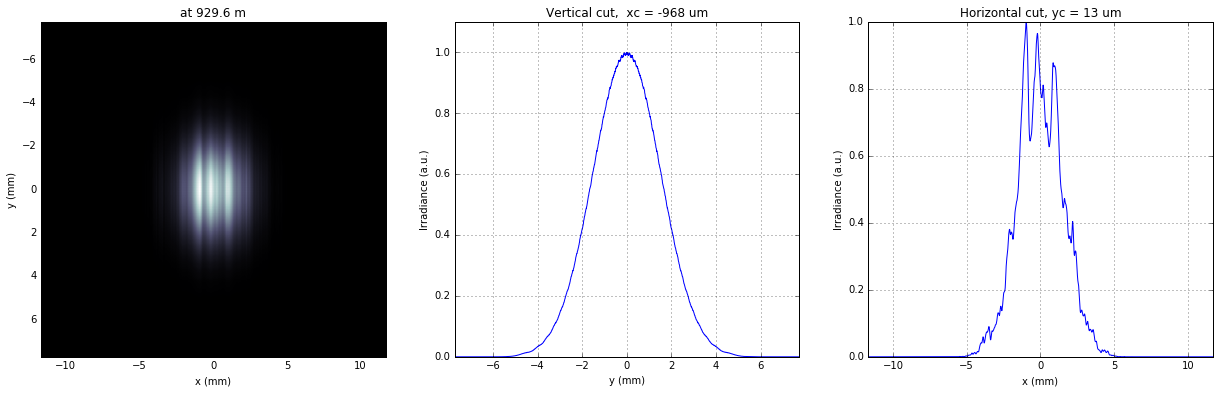

In [12]:
print('*****Imperfect HOM mirror, at KB aperture')
plot_wfront(mwf, 'at '+str(z1+z2)+' m',False, False, 1e-5,1e-5,'x', True)
#plt.set_cmap('bone') #set color map, 'bone', 'hot', etc
plt.axis('tight')    
print('FWHMx [mm], theta_fwhm [urad]:',calculate_fwhm_x(mwf)*1e3,calculate_fwhm_x(mwf)/(z1+z2)*1e6)
print('FWHMy [mm], theta_fwhm [urad]:',calculate_fwhm_y(mwf)*1e3,calculate_fwhm_y(mwf)/(z1+z2)*1e6)

### Propagating through BL2 beamline. Focused beam: perfect KB

In [13]:
print('*****Focused beam: perfect KB')
bSaved = False
z3 = dhkb_vkb
z4 = dvkb_foc 
z4 = vkbfoc #distance to focal plane

#HKB = SRWLOptMirEl(_p=d2hkb, _q=dhkb_foc, _ang_graz=thetaKB, _r_sag=1.e+40, _size_tang=0.85, _nvx=cos(thetaKB), _nvy=0, _nvz=-sin(thetaKB), _tvx=-sin(thetaKB), _tvy=0, _x=0, _y=0, _treat_in_out=1) #HKB Ellipsoidal Mirror
#VKB = SRWLOptMirEl(_p=d2vkb, _q=dvkb_foc, _ang_graz=thetaKB, _r_sag=1.e+40, _size_tang=0.85, _nvx=0, _nvy=cos(thetaKB), _nvz=-sin(thetaKB), _tvx=0, _tvy=-sin(thetaKB), _x=0, _y=0, _treat_in_out=1) #VKB Ellipsoidal Mirror
#HKB = SRWLOptL(hkbfoc) #HKB as Thin Lens
#VKB = SRWLOptL(1e23,vkbfoc) #VKB as Thin Lens
Drift_foc = SRWLOptD(dvkb_foc)
#optBL2 = SRWLOptC([opApM1,  DriftM1_KB,opApKB, HKB,   Drift_KB,  VKB,  Drift_foc], 
#                    [ppM1,ppDriftM1_KB,ppApKB,ppHKB,ppDrift_KB,ppVKB,ppDrift_foc,ppFin]) 
optBL2 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB,opApKB, HKB,   Drift_KB,  VKB,  Drift_foc], 
                    [ppM1,ppTrErM1,ppDriftM1_KB,ppApKB,ppHKB,ppDrift_KB,ppVKB,ppDrift_foc]) 
optBL = optBL2
strBL = 'bl2'
pos_title = 'at sample position'
print('*****setting-up optical elements, beamline:', strBL)
bl = Beamline(optBL)
bl.append(Empty(), Use_PP(zoom=0.02, sampling=5.0))
print(bl)

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'.h5')
    print('save hdf5:', out_file_name)
else:
    out_file_name = None
    
startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min')

*****Focused beam: perfect KB
*****setting-up optical elements, beamline: bl2
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0028000000000000004
	Dy = 0.0028313537
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 300000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1500
		ny = 100
		xFin = 0.0014000000000000002
		xStart = -0.0014000000000000002
		yFin = 0.00141567685
		yStart = -0.00141567685
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.8, 2.4, 1.8, 0, 0, 0]
	L = 683.1
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 0.6, 8.0, 0.6, 4.0, 0, 0, 0]
	Dx = 0.0028000000000000004
	Dy = 0.002800

*****Focused beam: Focused beam: perfect KB
FWHMx [mm]: 0.000234193434075
FWHMy [mm]: 0.000152352450272
Coordinates of center, [mm]: -3.19354682829e-05 1.55461683951e-06
stepX, stepY [um]: 0.001935482926236052 0.0031092336790285112 

R-space
FWHMx [um], FWHMy [um]: 0.234193434075 0.152352450272


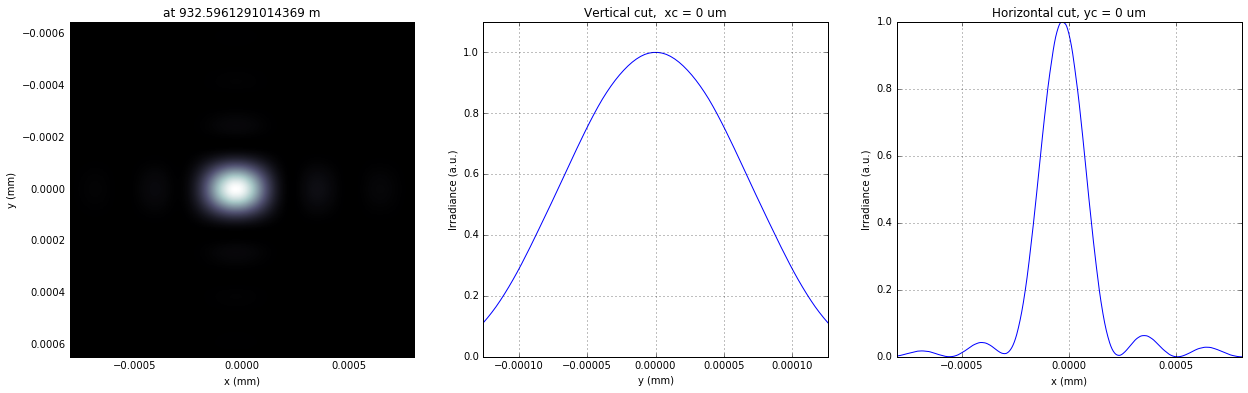

In [14]:
print('*****Focused beam: Focused beam: perfect KB')
bOnePlot = True
isHlog = False
isVlog = False
plot_wfront(mwf, 'at '+str(z1+z2+z3+z4)+' m',isHlog, isVlog, 1e-5,1e-5,'x', bOnePlot)
#plt.set_cmap('bone') #set color map, 'bone', 'hot', etc
plt.axis('tight')    
print('FWHMx [um], FWHMy [um]:',calculate_fwhm_x(mwf)*1e6,calculate_fwhm_y(mwf)*1e6)

*****HKB data  
*****VKB data  


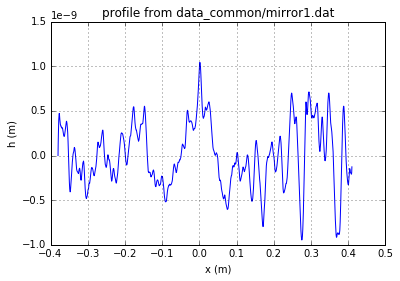

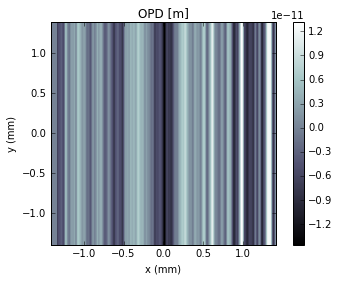

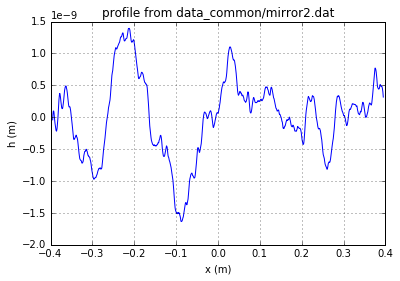

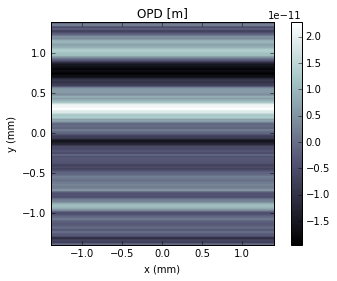

In [15]:
print('*****HKB data  ')
scale = 2 #scaling factor of mirror
opTrErHKB = SRWLOptT(1500, 100, horApKB, horApKB)
defineOPD(opTrErHKB, os.path.join(strInputDataFolder,'mirror1.dat'), 2, '\t', 'x',  thetaOM, scale)
opdTmp=np.array(opTrErHKB.arTr)[1::2].reshape(opTrErHKB.mesh.ny,opTrErHKB.mesh.nx)
plt.figure()
plot_2d(opdTmp, opTrErM1.mesh.xStart*1e3,opTrErM1.mesh.xFin*1e3,opTrErM1.mesh.yStart*1e3,opTrErM1.mesh.yFin*1e3,
        'OPD [m]', 'x (mm)', 'y (mm)')  
print('*****VKB data  ')
opTrErVKB = SRWLOptT(100, 1500, horApKB, horApKB)
defineOPD(opTrErVKB, os.path.join(strInputDataFolder,'mirror2.dat'), 2, ' ', 'y',  thetaOM, scale)
opdTmp=np.array(opTrErVKB.arTr)[1::2].reshape(opTrErVKB.mesh.ny,opTrErVKB.mesh.nx)
plt.figure()
plot_2d(opdTmp, opTrErVKB.mesh.xStart*1e3,opTrErVKB.mesh.xFin*1e3,opTrErVKB.mesh.yStart*1e3,opTrErVKB.mesh.yFin*1e3,
        'OPD [m]', 'x (mm)', 'y (mm)')  

In [16]:
print('*****Focused beam on focus: imperfect KB')
z3 = dhkb_vkb
z4 = dvkb_foc #distance to focal plane
#z4 = vkbfoc  #focus distance of lens

#HKB = SRWLOptMirEl(_p=d2hkb, _q=dhkb_foc, _ang_graz=thetaKB, _r_sag=1.e+40, _size_tang=0.85, _nvx=cos(thetaKB), _nvy=0, _nvz=-sin(thetaKB), _tvx=-sin(thetaKB), _tvy=0, _x=0, _y=0, _treat_in_out=1) #HKB Ellipsoidal Mirror
#VKB = SRWLOptMirEl(_p=d2vkb, _q=dvkb_foc, _ang_graz=thetaKB, _r_sag=1.e+40, _size_tang=0.85, _nvx=0, _nvy=cos(thetaKB), _nvz=-sin(thetaKB), _tvx=0, _tvy=-sin(thetaKB), _x=0, _y=0, _treat_in_out=1) #VKB Ellipsoidal Mirror
#HKB = SRWLOptL(hkbfoc) #HKB as Thin Lens
#VKB = SRWLOptL(1e23,vkbfoc) #VKB as Thin Lens
Drift_foc = SRWLOptD(z4)
optBL2 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB,opApKB, HKB,opTrErHKB,  Drift_KB,  VKB,opTrErVKB,  Drift_foc], 
                    [ppM1,ppTrErM1,ppDriftM1_KB,ppApKB,ppHKB,ppTrErM1,ppDrift_KB,ppVKB,ppTrErM1, ppDrift_foc]) 
optBL = optBL2


bl = Beamline(optBL)
bl.append(Empty(), Use_PP(zoom=0.02, sampling=5.0))

print(bl)

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'.h5')
    print('save hdf5:', out_file_name)
else:
    out_file_name = None
    
startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min')

*****Focused beam on focus: imperfect KB
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0028000000000000004
	Dy = 0.0028313537
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 300000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1500
		ny = 100
		xFin = 0.0014000000000000002
		xStart = -0.0014000000000000002
		yFin = 0.00141567685
		yStart = -0.00141567685
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.8, 2.4, 1.8, 0, 0, 0]
	L = 683.1
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 0.6, 8.0, 0.6, 4.0, 0, 0, 0]
	Dx = 0.0028000000000000004
	Dy = 0.0028000000000000004
	ap_or_ob = a
	shape = 

*****Focused beam: Focused beam: imperfect KB
FWHMx [mm]: 0.0023646431961
FWHMy [mm]: 0.00447881848302
Coordinates of center, [mm]: -0.00106118209005 -0.000676488208373
stepX, stepY [um]: 0.00969116063974761 0.015551453066055028 

R-space
FWHMx [um], FWHMy [um]: 2.3646431961 4.47881848302


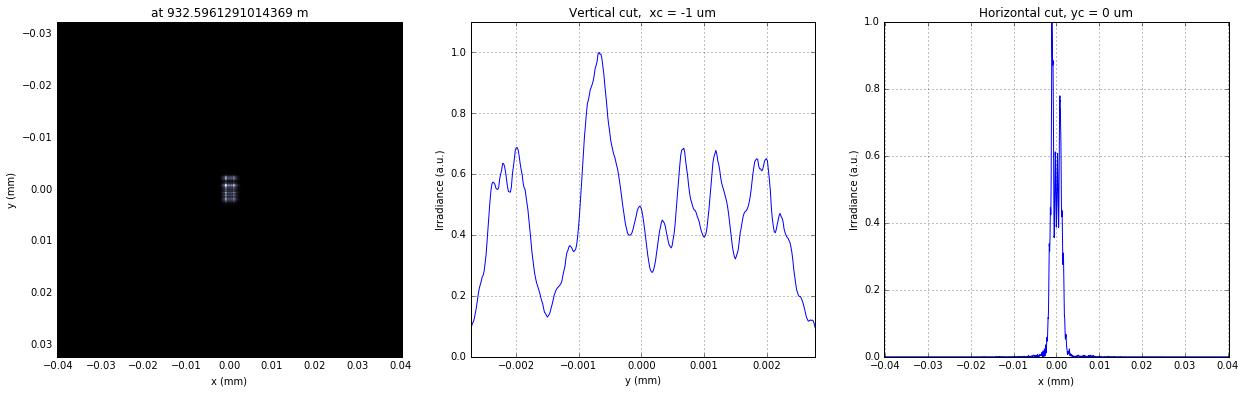

In [20]:
print('*****Focused beam: Focused beam: imperfect KB')
bOnePlot= True
isHlog = False
isVlog = False
bSaved = False
try:
    plot_wfront(mwf, 'at '+str(z1+z2+z3+z4)+' m',isHlog, isVlog, 1e-3,1e-3,'x', bOnePlot)
except ValueError as e:
    print(e)
#plt.set_cmap('bone') #set color map, 'bone', 'hot', etc
plt.axis('tight')    
print('FWHMx [um], FWHMy [um]:',calculate_fwhm_x(mwf)*1e6,calculate_fwhm_y(mwf)*1e6)

In [17]:
print('*****Focused beam behind focus: imperfect KB')
#optBL2 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB,opApKB, HKB,   Drift_KB,  VKB,  Drift_foc], 
#                    [ppM1,ppTrErM1,ppDriftM1_KB,ppApKB,ppHKB,ppDrift_KB,ppVKB,ppDrift_foc]) 
z3 = dhkb_vkb
#z4 = dvkb_foc #distance to focal plane
z4 = vkbfoc

#HKB = SRWLOptMirEl(_p=d2hkb, _q=dhkb_foc, _ang_graz=thetaKB, _r_sag=1.e+40, _size_tang=0.85, _nvx=cos(thetaKB), _nvy=0, _nvz=-sin(thetaKB), _tvx=-sin(thetaKB), _tvy=0, _x=0, _y=0, _treat_in_out=1) #HKB Ellipsoidal Mirror
#VKB = SRWLOptMirEl(_p=d2vkb, _q=dvkb_foc, _ang_graz=thetaKB, _r_sag=1.e+40, _size_tang=0.85, _nvx=0, _nvy=cos(thetaKB), _nvz=-sin(thetaKB), _tvx=0, _tvy=-sin(thetaKB), _x=0, _y=0, _treat_in_out=1) #VKB Ellipsoidal Mirror
#HKB = SRWLOptL(hkbfoc) #HKB as Thin Lens
#VKB = SRWLOptL(1e23,vkbfoc) #VKB as Thin Lens
Drift_foc = SRWLOptD(z4)
optBL2 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB,opApKB, HKB,opTrErHKB,  Drift_KB,  VKB,opTrErVKB,  Drift_foc], 
                    [ppM1,ppTrErM1,ppDriftM1_KB,ppApKB,ppHKB,ppTrErM1,ppDrift_KB,ppVKB,ppTrErM1, ppDrift_foc]) 
optBL = optBL2
strBL = 'bl2'
pos_title = 'at sample position'
print('*****setting-up optical elements, beamline:', strBL)
bl = Beamline(optBL)
print(bl)

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'.h5')
    print('save hdf5:', out_file_name)
else:
    out_file_name = None
    
startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min')

*****Focused beam behind focus: imperfect KB
*****setting-up optical elements, beamline: bl2
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0028000000000000004
	Dy = 0.0028313537
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 300000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1500
		ny = 100
		xFin = 0.0014000000000000002
		xStart = -0.0014000000000000002
		yFin = 0.00141567685
		yStart = -0.00141567685
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.8, 2.4, 1.8, 0, 0, 0]
	L = 683.1
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 0.6, 8.0, 0.6, 4.0, 0, 0, 0]
	Dx = 0.0028000000000000004

*****Focused beam behind focus: imperfect KB
FWHMx [mm]: 0.0023646431961
FWHMy [mm]: 0.00447881848302
Coordinates of center, [mm]: -0.00106118209005 -0.000676488208373
stepX, stepY [um]: 0.00969116063974761 0.015551453066055028 

R-space
FWHMx [um], FWHMy [um]: 2.3646431961 4.47881848302


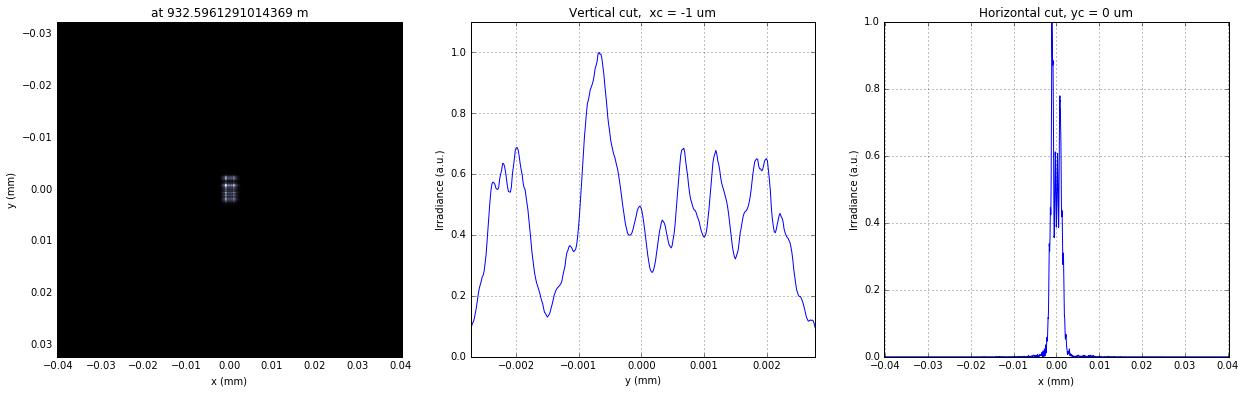

In [21]:
print('*****Focused beam behind focus: imperfect KB')
bOnePlot= True
isHlog = False
isVlog = False
bSaved = False
plot_wfront(mwf, 'at '+str(z1+z2+z3+z4)+' m',isHlog, isVlog, 1e-3,1e-3,'x', bOnePlot)
#plt.set_cmap('bone') #set color map, 'bone', 'hot', etc
plt.axis('tight')    
print('FWHMx [um], FWHMy [um]:',calculate_fwhm_x(mwf)*1e6,calculate_fwhm_y(mwf)*1e6)